In [1]:
import numpy as np 
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

## Load Data

In [38]:
train = pd.read_json('./../Data/train.json')

In [39]:
train.shape

(49352, 15)

In [43]:
def calculate_length(df):
    df["num_photos"] = df["photos"].apply(len)
    df["num_features"] = df["features"].apply(len)
    # .strip() removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
    df["num_description_words"] = df["description"].apply(lambda x: len(x.strip().split(" ")))
    return(df)
def calculate_date(df): 
    df["created"] = pd.to_datetime(df["created"])
    df["created_year"] = df["created"].dt.year
    df["created_month"] = df["created"].dt.month
    df["created_day"] = df["created"].dt.day
    df["created_hour"] = df["created"].dt.hour
    return(df)

In [44]:
train = calculate_length(train)
train = calculate_date(train)
train.shape

(49352, 22)

In [45]:
train.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,photos,price,street_address,num_photos,num_features,num_description_words,created_year,created_month,created_day,created_hour
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,5,0,94,2016,6,24,7
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,11,5,1,2016,6,12,12


In [36]:
train.loc[10000,'description'].strip()

u''

In [49]:
train.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('O'), dtype('<M8[ns]')], dtype=object)

In [52]:
numerical_features = train.select_dtypes(include=['int64', 'float64']).columns
numerical_features

Index([            u'bathrooms',              u'bedrooms',
                    u'latitude',            u'listing_id',
                   u'longitude',                 u'price',
                  u'num_photos',          u'num_features',
       u'num_description_words',          u'created_year',
               u'created_month',           u'created_day',
                u'created_hour'],
      dtype='object')

In [53]:
numerical_features = [x for x in numerical_features if x not in ['listing_id']]
numerical_features

[u'bathrooms',
 u'bedrooms',
 u'latitude',
 u'longitude',
 u'price',
 'num_photos',
 'num_features',
 'num_description_words',
 'created_year',
 'created_month',
 'created_day',
 'created_hour']

In [55]:
X = train[numerical_features]
y = train["interest_level"]

## Train model using Random Forest

In [56]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

In [57]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train, y_train)
y_val_pred = rf.predict_proba(X_val)
log_loss(y_val, y_val_pred)

0.61707908794236999

In [61]:
rf.classes_ #column 0 is high, column 1 is low, and column 2 is medium

array([u'high', u'low', u'medium'], dtype=object)

In [64]:
y_val_pred

array([[ 0.   ,  0.998,  0.002],
       [ 0.002,  0.957,  0.041],
       [ 0.074,  0.631,  0.295],
       ..., 
       [ 0.059,  0.608,  0.333],
       [ 0.035,  0.678,  0.287],
       [ 0.367,  0.261,  0.372]])

## Remove outliers and try Random Forest

In [109]:
price_ulimit = np.percentile(train.price.values, 99.5)
price_ulimit

15500.0

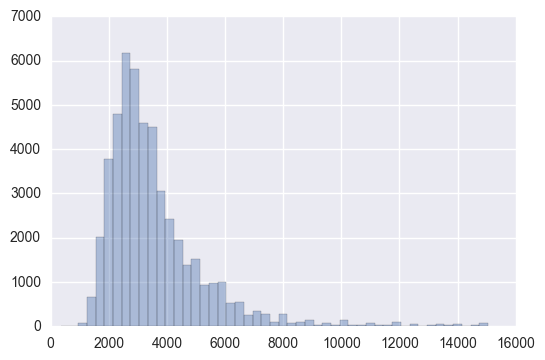

In [142]:
sns.distplot(train[train.price < price_ulimit].price.values, kde=False)

In [111]:
import scipy.stats as stats
stats.skew(train[train.price < price_ulimit].price.values)

2.4869146630675467

Price is skewed but lets leave it as it is since decision trees are robust to them.

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

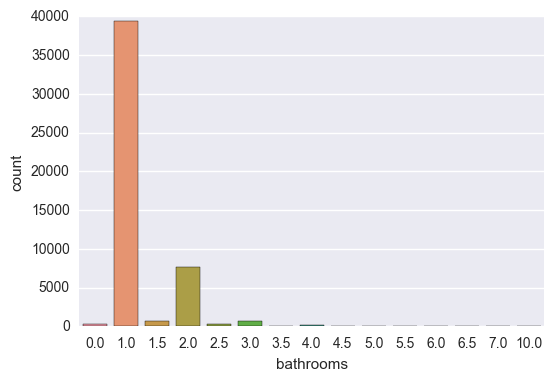

In [73]:
sns.countplot(data=train, x="bathrooms")

In [83]:
train.loc[[104459], ['bathrooms', 'bedrooms', 'description']].values 

array([[10.0, 2,
        u'***The building?s well-attended lobby welcomes the residents with its 24-hour doorman and concierge service as well as a fitness center, private storage rooms, bicycle storage, sauna and a laundry area on every floor. Many units have been completely renovated with beautiful new finishes, stone countertops and GE stainless steel appliances. Enjoy the Broadway theater district, Times Square, Central Park and exceptional dining and shopping<br /><br />***HUGE AS BIG AS A FOOT BALL FIELD AND FEATURES HIGH CEILING ,BRAND NEW KITCHEN ,MARBLE BATHROOM, TONS OF CLOSET SPACE ,UNOBSTRUCTED CITY VIEWS AND A TON OF LIGHT DUE TO ITS EXPOSURE AND HIGH FLOOR<br /><br />***TO SET UP TIME AND LOCATION CONTACT RUBENS 039-610-8860<br /><br /><p><a  website_redacted ']], dtype=object)

10 bathrooms for 2 bedrooms sounds unrealistic. Description suggests just one bathroom. Could it be a typo and it might just be 1 bathroom? Lets just fix it.

In [84]:
train.loc[[104459], ['bathrooms']] = 1

In [89]:
train[train.bathrooms>5][['bedrooms', 'bathrooms']] # the rest looks realistic

,bedrooms,bathrooms
13701,5,6.0
26937,7,6.5
30788,5,6.0
35053,5,5.5
52189,4,5.5
66485,5,5.5
79611,5,6.0
84566,5,7.0
91709,6,6.0
96387,4,5.5


In [90]:
train[train.bedrooms>5][['bedrooms', 'bathrooms']]

,bedrooms,bathrooms
103313,6,4.0
104366,6,4.0
104687,7,3.0
10624,6,3.0
106350,6,5.0
108557,6,3.0
112409,6,4.0
11313,8,4.0
118793,6,3.0
15980,6,4.0


In [92]:
train.loc[[23845], 'description'].values

array([ u'Spacious 6 Bed - HIgh ceilings - Gushing lights.<br /><br />Apartment features 1.5 marble baths - granite kitchen with a dishwasher - in unit washer & dryer - hardwood floors.<br /><br />located in Midtown West steps from the Theatre District nightlife and restaurants  - just around the corner from M11 & M104 bus service, A, C, E, subway lines and all transportation.<br /><br />Call or Email and Text for exclusive Showing!<br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><p><a  website_redacted '], dtype=object)

In [112]:
train[train.price>price_ulimit].interest_level.value_counts()

low     245
high      1
Name: interest_level, dtype: int64

Looks like anything outside the u_limit, we can predict as low!

### Fit a model using only the data that is within 99.5 percentiles of prices

In [113]:
rf2 = RandomForestClassifier(n_estimators=1000)
rf2.fit(X_train[X_train.price<price_ulimit], y_train[X_train.price<price_ulimit])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [117]:
X_val.shape

(16287, 12)

In [116]:
X_val[X_val.price>price_ulimit].shape

(99, 12)

In [120]:
y_val_pred = rf2.predict_proba(X_val[X_val.price<price_ulimit])
log_loss(y_val[X_val.price<price_ulimit], y_val_pred)

0.62103997743430239

In [129]:
y_val[X_val.price>price_ulimit].value_counts()

low    99
Name: interest_level, dtype: int64

In [130]:
y_val_pred = rf2.predict_proba(X_val)
log_loss(y_val, y_val_pred)

0.61781702733944877

In [140]:
y_val_pred[X_val.price>price_ulimit]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  if __name__ == '__main__':


array([[ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       ..., 
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.]])

In [141]:
rf2.classes_

array([u'high', u'low', u'medium'], dtype=object)

Removing outliers doesn't really seem to help when doing Random Forests! It makes sense because tree based models are more robust to outliers. 

To improve results, we will need to do gridsearch and find the optimal parameters for random forest. This is just a starter script. We should also leverage more features than just the numerical features.